In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error

import time
import tqdm
import torch

from torch.utils.data import DataLoader

%run models/models.ipynb

plt.style.use('dark_background')

### Datasets

In [2]:
OPTIONS_DATASET_PATH = 'simulated_prices/option_prices_medium.xlsx'

# OPTION_PROBABILITIES_PATH = 'simulated_prices/option_probabilities_100k.xlsx'
OPTION_PROBABILITIES_PATH = 'simulated_prices/complete_option_probabilities_10k.csv'

In [3]:
class OptionsDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path):
        
        x_column_names = [
            'initial_stock_price', 
            # 'strike_price', 
            # 'time_to_maturity',
            # 'risk_free_interest_rate',
            # 'dividend_rate',
            'volatility',
            # 'time_steps_count',
            # 'paths_count'
        ]

        data = pd.read_excel(dataset_path)
        
        self.data = data

        data.volatility = data.volatility * 100
        
        self.fields = data[x_column_names].to_numpy()
        self.target = data['option_price'].to_numpy()
        
        self.embedding_dimensions = np.max(self.fields, axis=0).astype(int) + 1
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.target[index]
        
        return fields, target
    
    
    def plot(self):

        initial_stock_prices = self.data['initial_stock_price'].to_numpy().reshape(-1, 1)
        option_prices = self.data['option_price'].to_numpy()

        plt.scatter(initial_stock_prices, option_prices, s=0.01)
        plt.xlabel("Initial stock price")
        plt.ylabel("Option price");

In [4]:
class BinaryOptionsDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path):
        
        data = pd.read_excel(dataset_path)
        
        data.volatility = data.volatility * 100
        
        # Binary
        
        initial_prices = data['initial_stock_price'].to_numpy()
        volatilities = data['volatility'].to_numpy()
        
        binary_initial_prices = np.array([self.encode_to_bits(initial_price) 
                                          for initial_price in initial_prices])
        
        binary_volatilities = np.array([self.encode_to_bits(volatility, dtype='>i1') 
                                        for volatility in volatilities])
        
        binary_fields = np.hstack((binary_initial_prices, binary_volatilities))
        
        self.data = data        
        
        self.fields = binary_fields
        self.target = data['option_price'].to_numpy()
        
        self.embedding_dimensions = np.max(self.fields, axis=0).astype(int) + 1       
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.target[index]
        
        return fields, target
    

    def encode_to_bits(self, number, dtype='>f'):
    
        number_bytes = np.array([number], dtype=dtype)

        integer_view = number_bytes.view('uint8')

        bits = np.unpackbits(integer_view)

        return bits  
    
    
    def plot(self):

        initial_stock_prices = self.data['initial_stock_price'].to_numpy().reshape(-1, 1)
        option_prices = self.data['option_price'].to_numpy()

        plt.scatter(initial_stock_prices, option_prices, s=0.01)
        plt.xlabel("Initial stock price")
        plt.ylabel("Option price");

In [5]:
class OptionProbabilitiesDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, binary=True):
        
        pd.read_excel(dataset_path)

        data.volatility = data.volatility * 100

        y_column = 'probability'
        x_columns = np.setdiff1d(data.columns, y_column)
        
        encoding_formats = {'default': '>f', 'volatility': '>i1'}
        
        default_format = encoding_formats['default']
        
        # Fields
        
        fields_list = []
        
        for column_name in x_columns:
            
            print("column_name:", column_name) 
            
            column = data[column_name]
            
            if binary:               
                
                encoding_format = encoding_formats.get(column_name, default_format)
                
                encoded_values = []
                
                for value in column:
                    
                    encoded_value = self.encode_to_bits(value, dtype=encoding_format) 
                    
                    encoded_values.append(encoded_value)
                    
                column = np.array(encoded_values)
            
            fields_list.append(column)
        
        fields = np.hstack(fields_list)
              
        self.data = data        
        
        self.fields = fields
        self.target = data[y_column].to_numpy()
        
        self.embedding_dimensions = np.max(self.fields, axis=0).astype(int) + 1       
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.target[index]
        
        return fields, target
    

    def encode_to_bits(self, number, dtype='>f'):
    
        number_bytes = np.array([number], dtype=dtype)

        integer_view = number_bytes.view('uint8')

        bits = np.unpackbits(integer_view)

        return bits  
    
    
    def plot(self):

        initial_stock_prices = self.data['initial_stock_price'].to_numpy().reshape(-1, 1)
        option_prices = self.data['option_price'].to_numpy()

        plt.scatter(initial_stock_prices, option_prices, s=0.01)
        plt.xlabel("Initial stock price")
        plt.ylabel("Option price");

In [6]:
class ChunkDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, binary=True, scheme=None, 
                 chunk_size = 10000, dataset_size = 101 * 101 * 10000):
        
        # Scheme
        
        default_scheme = {'target_column': 'probability',
                          'field_columns':
                              {'initial_stock_price': ('>f', 32),
                               'volatility': ('>i1', 8),
                               'option_price': ('>f', 32)}}                          
        
        scheme = default_scheme if scheme is None else scheme

        target_column = scheme['target_column']
        fields_scheme = scheme['field_columns']
        
        
        # Data
        
        print("Reading data")        

        chunks_count = dataset_size // chunk_size        
              
        dataset_iterator = pd.read_csv(dataset_path, iterator=True, chunksize=chunk_size)
        
        chunk_tracker = tqdm.tqdm(dataset_iterator,
                                  desc=f"Loading",
                                  ncols=110,
                                  unit='chunk',
                                  total=chunks_count)                          
        # Loading
        
        if binary:            
            fields_count = sum(bit_count for encoding_format, bit_count in fields_scheme.values())
            fields_dtype = 'int8'
        else:            
            fields_count = len(scheme)
            fields_dtype = float
        
        self.fields = np.zeros(shape=(dataset_size, fields_count), dtype=fields_dtype)
        self.targets = np.zeros(shape=dataset_size)
        
        row_offset = 0

        for chunk in chunk_tracker:

            column_offset = 0

            for column_name, (encoding_format, column_size) in fields_scheme.items():
                
                # if column_name == 'initial_stock_price':                    
                #     print(chunk[column_name])

                if binary:
                    column = self.encode_to_bits(chunk[column_name], 
                                                 dtype=encoding_format, 
                                                 bits_count=column_size)                        
                else:                        
                    column = chunk[column_name].to_numpy().reshape(-1, 1)                        
                    column_size = 1                        

                self.fields[row_offset : row_offset + chunk_size, 
                            column_offset : column_offset + column_size] = column

                column_offset += column_size
                
            self.targets[row_offset : row_offset + chunk_size] = chunk[target_column]

            row_offset += chunk_size
       
        self.embedding_dimensions = np.max(self.fields, axis=0).astype(int) + 1
        
        print("fields.shape:", self.fields.shape)
        print("targets.shape:", self.targets.shape) 
        print("embedding_dimensions:", self.embedding_dimensions)     
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.target[index]
        
        return fields, target
    

    def encode_to_bits(self, inputs, dtype='>f', bits_count=32):
    
        number_bytes = np.array([inputs], dtype=dtype)

        integer_view = number_bytes.view('uint8')

        bits_vector = np.unpackbits(integer_view)
        
        bits = bits_vector.reshape(-1, bits_count)

        return bits

In [7]:
# OPTION_PROBABILITIES_PATH = 'simulated_prices/option_probabilities_100k.xlsx'
OPTION_PROBABILITIES_PATH = 'simulated_prices/complete_option_probabilities_10k.csv'


d = ChunkDataset(OPTION_PROBABILITIES_PATH, binary=True)

Reading data


Loading: 100%|██████████████████████████████████████████████████████| 10201/10201 [00:57<00:00, 178.25chunk/s]


fields.shape: (102010000, 72)
targets.shape: (102010000,)
embedding_dimensions: [1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [8]:
d.fields[10000000:10000100]

array([[0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 1]], dtype=int8)

### Option Prices - 3D Plot

In [57]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

from IPython.display import HTML   


class OptionPricesPlot:

    def __init__(self,
                 elevation=10,
                 initial_azimuth=230):
        
        self.elevation = elevation
        self.initial_azimuth = initial_azimuth
        

    def plot(self, 
             plot_predictions=True, 
             plot_target=True):
                    
        self.calculate_grids() 

        figure = plt.figure(figsize=(5, 5))

        ax = figure.add_subplot(1, 1, 1, 
                                projection='3d', 
                                computed_zorder=False)

        if plot_predictions and 'predictions' in globals():

            predicted_surface = ax.plot_surface(self.initial_stock_prices_grid,
                                                self.volatilities_grid,
                                                self.predicted_option_prices_grid,
                                                # cmap='copper',
                                                color='indigo',
                                                linewidth=30,
                                                label='Predicted option prices',
                                                # alpha=1.0,
                                                zorder=500,
                                                antialiased=False)

        if plot_target:

            target_surface = ax.plot_surface(self.initial_stock_prices_grid,
                                             self.volatilities_grid,
                                             self.target_option_prices_grid,
                                             cmap='plasma',
                                             linewidth=30, 
                                             label='Target option prices',
                                             alpha=0.5,
                                             zorder=1000,
                                             antialiased=False)

        ax.view_init(elev=self.elevation, azim=self.initial_azimuth)
        
        ax.zaxis.set_rotate_label(False)

        ax.set_xlabel('Initial Stock Price')
        ax.set_ylabel('Volatility')
        ax.set_zlabel('Option Price', rotation=90)
        
        # figure.patch.set_facecolor('black')
        figure.patch.set_facecolor(ax.patch.get_facecolor())
        
        self.figure = figure
        self.ax = ax
        
 
    def animation_step(self, frame_index):

        azimuth = self.initial_azimuth + self.azimuth_step * frame_index

        self.ax.view_init(elev=self.elevation, azim=azimuth)

        
    def render_animation(self,
                         frames_count=12,
                         rotation_period=10):
        
        self.frames_count = frames_count
        self.rotation_period = rotation_period
        
        self.azimuth_step = 360 // frames_count
        self.frames_per_second = frames_count // rotation_period

        self.animation_model = animation.FuncAnimation(self.figure, 
                                                       self.animation_step, 
                                                       frames=self.frames_count, 
                                                       interval=50)

        rendered_animation = HTML(self.animation_model.to_jshtml(fps=self.frames_per_second))

        return rendered_animation


    def save_to_gif(self, path):

        self.animation_model.save(path, writer='pillow', fps=self.frames_per_second, dpi=100)
        

    def calculate_grids(self):
    
        # Data
        
        data = dataset.data

        initial_stock_prices = data.initial_stock_price.to_numpy()
        volatilities = data.volatility.to_numpy()
        option_prices= data.option_price.to_numpy()

        # Grids

        grid_side_size = np.sqrt(initial_stock_prices.shape[0]).astype(int)

        self.initial_stock_prices_grid = initial_stock_prices.reshape((grid_side_size, grid_side_size))
        self.volatilities_grid = volatilities.reshape((grid_side_size, grid_side_size))

        self.target_option_prices_grid = option_prices.reshape(-1, grid_side_size)
        
        if 'predictions' in globals():
        
            self.predicted_option_prices_grid = predictions.detach().reshape(-1, grid_side_size)

        # print(self.initial_stock_prices_grid, 
        #       self.volatilities_grid, 
        #       self.target_option_prices_grid, 
        #       self.predicted_option_prices_grid)

### Option Prices - Trainers

In [58]:
class Trainer:

    def __init__(self, dataset, model, criterion, metric, optimizer):
        
        self.dataset = dataset
        self.model = model
        self.criterion = criterion
        self.metric = metric
        self.optimizer = optimizer        
        
        self.fields = torch.tensor(dataset.fields, dtype=int)
        self.target = torch.tensor(dataset.target, dtype=int)
        
        self.plot = OptionPricesPlot()
        
        
    def one_step(self):

        predictions = self.model(self.fields)

        loss = self.criterion(predictions, self.target.float())

        self.model.zero_grad()
        
        loss.backward()
        
        self.optimizer.step()

        return predictions, loss
    
    
    def train(self, epochs=10):
    
        self.model.train()

        for epoch in range(epochs):
            
            predictions, loss = self.one_step()
            
        print('loss:', loss)
        
        return predictions

In [59]:
class Splitter:
    
    def __init__(self, dataset, shuffle=None, 
                 train_rate=0.8, valid_rate=0.1, 
                 batch_size=2048, dataloader_workers_count=8,
                 epochs_logging_interval=1):
             
        self.epochs_logging_interval = epochs_logging_interval
        
        dataset_length = len(dataset)

        train_length = int(dataset_length * train_rate)
        valid_length = int(dataset_length * valid_rate)

        test_length = dataset_length - train_length - valid_length

        train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
            dataset, 
            (train_length, valid_length, test_length)
        )

        self.train_data_loader = DataLoader(train_dataset,
                                            shuffle=shuffle,
                                            batch_size=batch_size, 
                                            num_workers=dataloader_workers_count)
        
        self.valid_data_loader = DataLoader(valid_dataset,
                                            shuffle=shuffle,                                        
                                            batch_size=batch_size, 
                                            num_workers=dataloader_workers_count)
        
        self.test_data_loader = DataLoader(test_dataset,
                                           shuffle=shuffle,
                                           batch_size=batch_size,
                                           num_workers=dataloader_workers_count)
        
        print("dataset_length:", dataset_length)
        print("train_length:", train_length)
        print("valid_length:", valid_length)
        print("test_length:", test_length)
        
    
class SplitTrainer:

    def __init__(self, 
                 # dataset, 
                 model, criterion, metric, optimizer, splitter, device='cpu'):
        
        self.device = torch.device(device)
        
        self.model = model.to(device)
        self.criterion = criterion
        self.metric = metric
        self.optimizer = optimizer
        self.splitter = splitter
        
        self.train_data_loader = self.splitter.train_data_loader
        self.valid_data_loader = self.splitter.valid_data_loader
        self.test_data_loader = self.splitter.test_data_loader
        
        self.scores = []
        
        self.epochs_logging_interval = self.splitter.epochs_logging_interval
        
        self.plot = OptionPricesPlot()
        
        # TODO: EarlyStopper
    
    
    def fit(self, epochs=10):
    
        for epoch in range(epochs):
            
            epoch_start_time = time.time()
            
            train_batch_tracker = tqdm.tqdm(
                self.train_data_loader,
                desc=f"Epoch: {epoch + 1}/{epochs}",
                ncols=110,
                unit=' batches',
                # smoothing=0,
                # mininterval=1.0
            )            
            
            self.train(train_batch_tracker)
            
            score, _ = self.test(self.valid_data_loader)
            
            self.scores.append(score)
            
            epoch_duration = time.time() - epoch_start_time
            
            print(f"Validation {self.metric.__name__}: {score:.02f}, "
                  f"Duration: {epoch_duration:.02f} seconds") 
            
        total_score, total_predictions = self.test(self.test_data_loader)
        
        self.predictions = total_predictions
        
        print(f"\nTotal - Test {metric.__name__}: {total_score:.02f}")
    
    
    def train(self, train_batch_tracker):

        self.model.train()

        total_loss = 0

        for batch, (fields, target) in enumerate(train_batch_tracker):

            fields = fields.to(self.device).int()
            target = target.to(self.device)      
            
            predictions = self.model(fields)

            loss = self.criterion(predictions, target.float())

            self.model.zero_grad()

            loss.backward()

            self.optimizer.step()

            total_loss += loss.item()

            if not (batch + 1) % self.epochs_logging_interval:

                loss = total_loss / self.epochs_logging_interval

                train_batch_tracker.set_postfix(loss=loss)

                total_loss = 0
                
                
    def test(self, data_loader):
        
        self.model.eval()
    
        targets = []
        predictions = []

        with torch.no_grad():

            for fields, target in data_loader:

                fields = fields.to(self.device).int()
                target = target.to(self.device)

                prediction = self.model(fields)

                targets.extend(target.tolist())
                predictions.extend(prediction.tolist())

        score = self.metric(targets, predictions)
        
        return score, predictions

### Options - Get Weights

In [60]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6


# Data

dataset = OptionProbabilitiesDataset(OPTION_PROBABILITIES_PATH)

embedding_dimensions = dataset.embedding_dimensions

# Model

%run models/models.ipynb

model = CustomFactorizationMachine(embedding_dimensions, embed_dim=16)

criterion = torch.nn.MSELoss()

metric = mean_squared_error

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)

In [61]:
embedding_weights = model.state_dict()['embedding.embedding.weight']
linear_weights = model.state_dict()['linear.fc.weight']
linear_bias = model.state_dict()['linear.bias']

# model.state_dict()

In [62]:
splitter = Splitter(dataset, batch_size=100)
# splitter = Splitter(dataset, shuffle=True, batch_size=100)

dataset_length: 100000
train_length: 80000
valid_length: 10000
test_length: 10000


In [63]:
trainer = SplitTrainer(model=model,
                       criterion=criterion,
                       metric=metric,
                       optimizer=optimizer,
                       splitter=splitter)

In [65]:
trainer.fit(epochs=10)

Epoch: 1/10: 100%|██████████████████████████████████████| 800/800 [00:04<00:00, 183.32 batches/s, loss=0.0351]


Validation mean_squared_error: 0.01, Duration: 4.69 seconds


Epoch: 2/10: 100%|██████████████████████████████████████| 800/800 [00:04<00:00, 180.00 batches/s, loss=0.0334]


Validation mean_squared_error: 0.01, Duration: 4.77 seconds


Epoch: 3/10: 100%|██████████████████████████████████████| 800/800 [00:04<00:00, 184.32 batches/s, loss=0.0289]


Validation mean_squared_error: 0.01, Duration: 4.69 seconds


Epoch: 4/10: 100%|███████████████████████████████████████| 800/800 [00:04<00:00, 186.67 batches/s, loss=0.025]


Validation mean_squared_error: 0.01, Duration: 4.62 seconds


Epoch: 5/10: 100%|██████████████████████████████████████| 800/800 [00:04<00:00, 180.88 batches/s, loss=0.0237]


Validation mean_squared_error: 0.02, Duration: 4.77 seconds


Epoch: 6/10: 100%|██████████████████████████████████████| 800/800 [00:04<00:00, 181.34 batches/s, loss=0.0242]


Validation mean_squared_error: 0.02, Duration: 4.78 seconds


Epoch: 7/10: 100%|██████████████████████████████████████| 800/800 [00:04<00:00, 183.97 batches/s, loss=0.0245]


Validation mean_squared_error: 0.02, Duration: 4.69 seconds


Epoch: 8/10: 100%|██████████████████████████████████████| 800/800 [00:04<00:00, 186.31 batches/s, loss=0.0234]


Validation mean_squared_error: 0.02, Duration: 4.67 seconds


Epoch: 9/10: 100%|███████████████████████████████████████| 800/800 [00:04<00:00, 187.07 batches/s, loss=0.021]


Validation mean_squared_error: 0.02, Duration: 4.63 seconds


Epoch: 10/10: 100%|█████████████████████████████████████| 800/800 [00:04<00:00, 184.89 batches/s, loss=0.0185]


Validation mean_squared_error: 0.02, Duration: 4.70 seconds

Total - Test mean_squared_error: 0.02


In [51]:
scores_dict['Shuffle'] = trainer.scores

In [52]:
trainer.scores

[39160531.12934897,
 32860177.059274632,
 28873320.0972045,
 26174887.75458354,
 24264593.535161413,
 22903222.94922511,
 21840685.142780546,
 21028628.231348082,
 20368037.04562128,
 19799398.858446542]

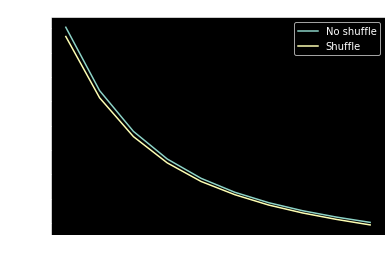

In [53]:
for mode, scores in scores_dict.items():
    
    plt.plot(scores, label=mode)
    
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

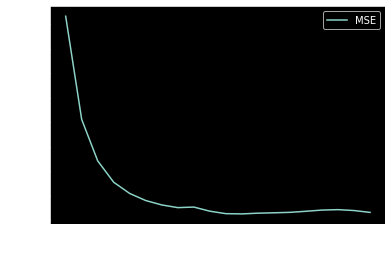

In [66]:
plt.plot(trainer.scores, label="MSE")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

### Options - Binary Features

In [84]:
# Data

binary_dataset = BinaryOptionsDataset(OPTIONS_DATASET_PATH)

binary_embedding_dimensions = binary_dataset.embedding_dimensions

# Model

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6

%run models/models.ipynb

# model = CustomLogisticRegression(binary_embedding_dimensions)

# model = CustomFactorizationMachine(binary_embedding_dimensions, embed_dim=16)

model = CustomDeepFactorizationMachineModel(binary_embedding_dimensions, 
                                            embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

# model = CustomLinearRegression(input_dimensions=len(binary_embedding_dimensions),
#                                output_dimensions=1)

criterion = torch.nn.MSELoss()

metric = mean_squared_error

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)

# criterion = torch.nn.BCELoss()

# optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

In [24]:
binary_splitter = Splitter(binary_dataset, batch_size=10)

dataset_length: 10201
train_length: 8160
valid_length: 1020
test_length: 1021


In [25]:
binary_split_trainer = SplitTrainer(model=model,
                                    criterion=criterion,
                                    metric=metric,
                                    optimizer=optimizer,
                                    splitter=binary_splitter)

In [ ]:
binary_split_trainer.fit(epochs=10)

Epoch: 1/10: 100%|██████████████████████████████████████| 816/816 [00:02<00:00, 301.74 batches/s, loss=1.9e+7]


Validation mean_squared_error: 25208291.90, Duration: 2.95 seconds


Epoch: 2/10: 100%|██████████████████████████████████████| 816/816 [00:02<00:00, 304.33 batches/s, loss=1.9e+7]


Validation mean_squared_error: 25133815.61, Duration: 2.94 seconds


Epoch: 3/10: 100%|█████████████████████████████████████| 816/816 [00:02<00:00, 299.38 batches/s, loss=1.89e+7]


Validation mean_squared_error: 25059571.20, Duration: 3.00 seconds


Epoch: 4/10: 100%|█████████████████████████████████████| 816/816 [00:02<00:00, 292.78 batches/s, loss=1.88e+7]


Validation mean_squared_error: 24985535.21, Duration: 3.04 seconds


Epoch: 5/10: 100%|█████████████████████████████████████| 816/816 [00:02<00:00, 300.26 batches/s, loss=1.88e+7]


Validation mean_squared_error: 24911694.58, Duration: 2.98 seconds


Epoch: 6/10:   0%|                                                | 0/816 [00:00<?, ? batches/s, loss=2.45e+7]

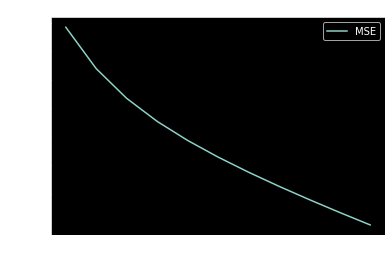

In [22]:
plt.plot(binary_split_trainer.scores, label="MSE")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

### Options Prices - Whole Trainer

In [154]:
# Data

dataset = OptionsDataset(OPTIONS_DATASET_PATH)

embedding_dimensions = dataset.embedding_dimensions


# Model

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6

%run models/models.ipynb

# model = CustomDeepFactorizationMachineModel(embedding_dimensions, 
#                                             embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

# model = CustomLinearRegression(input_dimensions=len(embedding_dimensions),
#                                output_dimensions=1)

criterion = torch.nn.MSELoss()

metric = mean_squared_error

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)

# # Others

# model = CustomLogisticRegression(embedding_dimensions)

# model = CustomFactorizationMachine(embedding_dimensions, embed_dim=16)

# criterion = torch.nn.BCELoss()

# optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)


trainer = Trainer(dataset=dataset,
                  model=model,
                  criterion=criterion,
                  metric=metric,
                  optimizer=optimizer)

In [156]:
predictions = trainer.train(epochs=1000)

loss: tensor(24750014., grad_fn=<MseLossBackward0>)


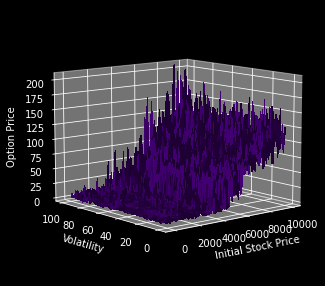

In [8]:
trainer.plot.plot(plot_target=False)

In [31]:
# trainer.plot.render_animation()

In [202]:
# trainer.plot.save_to_gif('images/test.gif')

In [203]:
# # 2D Plot

# initial_stock_prices = trainer.option_prices_dataset.data.initial_stock_price
# target_option_prices = trainer.option_prices_dataset.target
# predicted_option_prices = predictions.detach()

# plt.scatter(initial_stock_prices, target_option_prices, s=0.05)
# plt.scatter(initial_stock_prices, predicted_option_prices, s=0.05);

### Options - Split Trainer

In [146]:
# Data

dataset = OptionsDataset(OPTIONS_DATASET_PATH)

embedding_dimensions = dataset.embedding_dimensions


# Model

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6

%run models/models.ipynb

# model = CustomDeepFactorizationMachineModel(embedding_dimensions, 
#                                             embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

# model = CustomLinearRegression(input_dimensions=len(embedding_dimensions),
#                                output_dimensions=1)

criterion = torch.nn.MSELoss()

metric = mean_squared_error

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)

# # Others

# model = CustomLogisticRegression(embedding_dimensions)

model = CustomFactorizationMachine(embedding_dimensions, embed_dim=16)

# criterion = torch.nn.BCELoss()

# optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

In [147]:
splitter = Splitter(dataset, batch_size=10)

dataset_length: 10201
train_length: 8160
valid_length: 1020
test_length: 1021


In [148]:
split_trainer = SplitTrainer(model=model,
                             criterion=criterion,
                             metric=metric,
                             optimizer=optimizer,
                             splitter=splitter)

In [151]:
split_trainer.fit(epochs=1)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:05<00:00, 147.16 batches/s, loss=3.34e+7]


Validation mean_squared_error: 25098753.25, Duration: 5.82 seconds

Total - Test mean_squared_error: 26315817.98


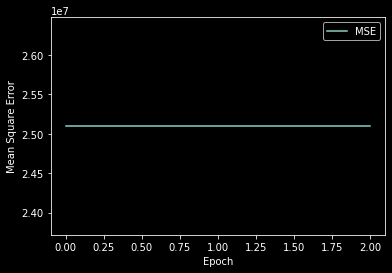

In [152]:
plt.plot(split_trainer.scores, label="MSE")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

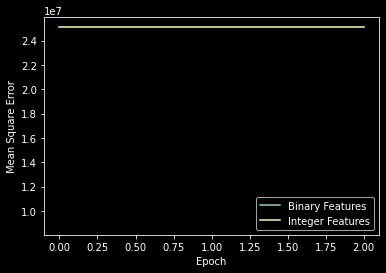

In [153]:
plt.plot(binary_split_trainer.scores, label="Binary Features")
plt.plot(split_trainer.scores, label="Integer Features")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

In [14]:
with torch.no_grad():

    predictions = split_trainer.model(torch.tensor(split_trainer.dataset.fields).int())

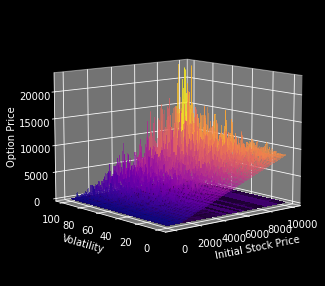

In [15]:
split_trainer.plot.plot(plot_target=True)

In [16]:
# split_trainer.plot.render_animation()

### Options - Model Comparison

In [8]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6
EPOCHS_COUNT = 1

# Binary

binary_dataset = BinaryOptionsDataset(OPTIONS_DATASET_PATH)

binary_splitter = Splitter(binary_dataset, batch_size=10)

binary_embedding_dimensions = binary_dataset.embedding_dimensions


# Models

binary_fm_model = CustomFactorizationMachine(binary_embedding_dimensions, embed_dim=16)

binary_deep_fm_model = CustomDeepFactorizationMachineModel(binary_embedding_dimensions,
                                                           embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

binary_linear_model = CustomLinearRegression(input_dimensions=len(binary_embedding_dimensions),
                                             output_dimensions=1)


criterion = torch.nn.MSELoss()

metric = mean_squared_error


binary_fm_optimizer = torch.optim.Adam(params=binary_fm_model.parameters(),
                                       lr=LEARNING_RATE,
                                       weight_decay=WEIGHT_DECAY)

binary_deep_fm_optimizer = torch.optim.Adam(params=binary_deep_fm_model.parameters(),
                                            lr=LEARNING_RATE,
                                            weight_decay=WEIGHT_DECAY)

binary_linear_optimizer = torch.optim.Adam(params=binary_linear_model.parameters(),
                                           lr=LEARNING_RATE,
                                           weight_decay=WEIGHT_DECAY)

binary_fm_trainer = SplitTrainer(model=binary_fm_model,
                                 criterion=criterion,
                                 metric=metric,
                                 optimizer=binary_fm_optimizer,
                                 splitter=binary_splitter)

binary_deep_fm_trainer = SplitTrainer(model=binary_deep_fm_model,
                                      criterion=criterion,
                                      metric=metric,
                                      optimizer=binary_deep_fm_optimizer,
                                      splitter=binary_splitter)

binary_linear_trainer = SplitTrainer(model=binary_linear_model,
                                     criterion=criterion,
                                     metric=metric,
                                     optimizer=binary_linear_optimizer,
                                     splitter=binary_splitter)

dataset_length: 10201
train_length: 8160
valid_length: 1020
test_length: 1021


In [19]:
binary_fm_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:03<00:00, 257.00 batches/s, loss=2.89e+6]


Validation mean_squared_error: 3353391.11, Duration: 3.45 seconds

Total - Test mean_squared_error: 3710378.33


In [20]:
binary_deep_fm_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:04<00:00, 182.80 batches/s, loss=8.89e+5]


Validation mean_squared_error: 1806434.89, Duration: 4.76 seconds

Total - Test mean_squared_error: 1973852.98


In [21]:
binary_linear_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:02<00:00, 283.63 batches/s, loss=2.31e+7]


Validation mean_squared_error: 22918524.62, Duration: 3.12 seconds

Total - Test mean_squared_error: 25722996.68


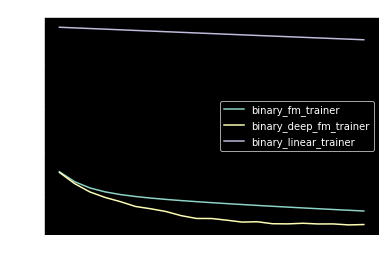

In [22]:
plt.plot(binary_fm_trainer.scores, label="binary_fm_trainer")
plt.plot(binary_deep_fm_trainer.scores, label="binary_deep_fm_trainer")
plt.plot(binary_linear_trainer.scores, label="binary_linear_trainer")
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

In [13]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6
EPOCHS_COUNTHS_COUNT = 1

# Binary

dataset = BinaryOptionsDataset(OPTIONS_DATASET_PATH)

splitter = Splitter(binary_dataset, batch_size=10)

embedding_dimensions = dataset.embedding_dimensions

# Models

fm_model = CustomFactorizationMachine(embedding_dimensions, embed_dim=16)

deep_fm_model = CustomDeepFactorizationMachineModel(embedding_dimensions,
                                                    embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

linear_model = CustomLinearRegression(input_dimensions=len(embedding_dimensions),
                                      output_dimensions=1)


criterion = torch.nn.MSELoss()

metric = mean_squared_error


fm_optimizer = torch.optim.Adam(params=fm_model.parameters(),
                                lr=LEARNING_RATE,
                                weight_decay=WEIGHT_DECAY)

deep_fm_optimizer = torch.optim.Adam(params=deep_fm_model.parameters(),
                                     lr=LEARNING_RATE,
                                     weight_decay=WEIGHT_DECAY)

linear_optimizer = torch.optim.Adam(params=linear_model.parameters(),
                                    lr=LEARNING_RATE,
                                    weight_decay=WEIGHT_DECAY)

fm_trainer = SplitTrainer(model=fm_model,
                          criterion=criterion,
                          metric=metric,
                          optimizer=fm_optimizer,
                          splitter=splitter)

deep_fm_trainer = SplitTrainer(model=deep_fm_model,
                               criterion=criterion,
                               metric=metric,
                               optimizer=deep_fm_optimizer,
                               splitter=splitter)

linear_trainer = SplitTrainer(model=linear_model,
                              criterion=criterion,
                              metric=metric,
                              optimizer=linear_optimizer,
                              splitter=splitter)

dataset_length: 10201
train_length: 8160
valid_length: 1020
test_length: 1021


In [23]:
fm_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:03<00:00, 255.62 batches/s, loss=3.38e+6]


Validation mean_squared_error: 3176578.63, Duration: 3.49 seconds

Total - Test mean_squared_error: 3414384.87


In [24]:
deep_fm_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:04<00:00, 178.25 batches/s, loss=2.85e+6]


Validation mean_squared_error: 1608093.32, Duration: 4.85 seconds

Total - Test mean_squared_error: 1675401.38


In [25]:
linear_trainer.fit(epochs=EPOCHS_COUNT)

Epoch: 1/1: 100%|██████████████████████████████████████| 816/816 [00:02<00:00, 288.57 batches/s, loss=3.44e+7]


Validation mean_squared_error: 23364332.11, Duration: 3.06 seconds

Total - Test mean_squared_error: 24982800.57


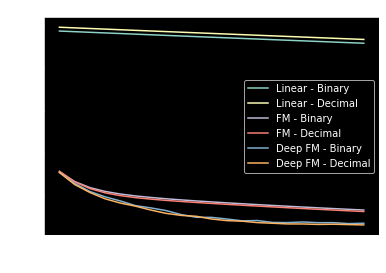

In [35]:
plt.plot(binary_linear_trainer.scores, label="Linear - Binary")
plt.plot(linear_trainer.scores, label="Linear - Decimal")

plt.plot(binary_fm_trainer.scores, label="FM - Binary")
plt.plot(fm_trainer.scores, label="FM - Decimal")

plt.plot(binary_deep_fm_trainer.scores, label="Deep FM - Binary")
plt.plot(deep_fm_trainer.scores, label="Deep FM - Decimal")

plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

### TODO

In [ ]:
# TODO:

# 1) Classical
#
# Add binary encoded input for FM 1
#
# Compare DeepFM and FM 4
#
# Multiple run (100) for same MC -> check results 5
#
# Save model data 5
#
# Normalize MSE 5
#
# FM not working 5
#
# Pytorch: Evaluate which part of DeepFM gives most part of value - is possible? 4
#
#
# 2) Quantum
#
# Quantum FM - mapping for Ising model 1
#
# Without Variational Auto-encoder 4
#
# Possibly: add binary encoder 4
#
# D-Wave simulator - via AWS Braket - (Jonas) 5